## Fitting a linear regression model with TensorFlow

**Goal:** In this notebook you will see how to use TensorFlow to fit the parameters (slope and intercept) of a simple linear regression model via gradient descent (GD). 

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** You work again with the systolic blood pressure and age data of 33 American women, which is generated and visualized in the upper part of the notebook. 

**Content:**

* fit a linear model via the sklearn machine learning library of python to get the fitted values of the intercept and slope as reference. 

* use the TensorFlow library to fit the parameter of the simple linear model via GD with the objective to minimize the MSE loss. 
    * define the computational graph of the model
    * define the loss and the optimizer
    * visualize the computational graph in tensorboard
    * fit the model parameters via GD and check the current values of the estimated model parameters and the loss after each updatestep
    * verify that the estimated parameters converge to the values which you got from the sklearn fit.  


[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_03/nb_ch03_03.ipynb)


#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.linear_model import LinearRegression

Here we read in the systolic blood pressure and the age of the 33 American women in our dataset. Then we use the sklearn library to find the optimal values for the slope a and the intercept b.

In [2]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217] 
x = np.asarray(x, np.float32) 
y = np.asarray(y, np.float32)

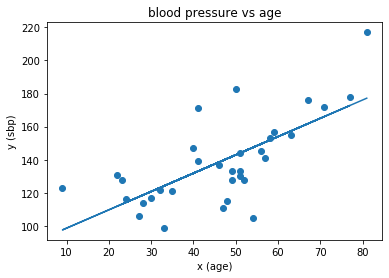

intercept =  87.67143 solpe =  1.1050216


In [3]:
plt.scatter(x=x,y=y)
plt.title("blood pressure vs age")
plt.xlabel("x (age)")
plt.ylabel("y (sbp)")

model = LinearRegression()
res = model.fit(x.reshape((len(x),1)), y)
predictions = model.predict(x.reshape((len(x),1)))
plt.plot(x, predictions)
plt.show()
print("intercept = ",res.intercept_,"solpe = ", res.coef_[0],)

## Tensorflow

We now use Tensorflow to first define the computational graph, then we will run the graph and automatically get the gradients of the loss w.r.t the variables to update them.

In [4]:
import tensorflow as tf

#### In Tensorflow we need to define the computational graph first



In [5]:
# x,y are one dimensional numpy arrays
# Defining the graph (construction phase)

tf.reset_default_graph()                                   # “Wipe the blackboard”, construct a new graph
a_  = tf.Variable(0.0, name='a_var')                       # Variables, with starting values, will be optimized later
b_  = tf.Variable(139.0, name='b_var')                     # we name them so that they look nicer in the graph
x_  = tf.constant(x, name='x_const')                       # Constants, these are fixed tensors holding the data values and cannot be changed by the optimization
y_  = tf.constant(y, name='y_const')  

y_hat_ = a_*x_ + b_                                        # we symbolically calculate y_hat    
loss_ = tf.reduce_mean(tf.square(y_ - y_hat_))             #The final result, the MSE. Still symbolical

writer = tf.summary.FileWriter("linreg/", tf.get_default_graph())
writer.close()

In [6]:
!ls linreg

events.out.tfevents.1566087769.e14c3fac61fa


#### Displaying the computational graph in TensorBord with colab

If you are using colab, it's currently (November 2018), there is no straight forward way to show the graph in TensorBoard. However, there is the possibility to tunnel from colab to your local machine. See  https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ or https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab. We will need to install some things, just run the next 3 cells.

<div class="alert alert-warning">
Following did not work for me from the jupyter notebook, but perhaps it is due to my set up. I had to run them manually from the terminal to get the tensor board to work
</div>

In [15]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

/bin/sh: 1: wget: not found
/bin/sh: 1: unzip: not found


In [13]:
# Start Tensor Board
LOG_DIR = './linreg'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

Now you can click on the link below and a new window will open where you can see the computational graph in Tensorboard

In [14]:
# Start the tunnel
get_ipython().system_raw('./ngrok http 6006 &')

# Tell the ip so that one can click on it
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d9ed0821.ngrok.io


####Let's run the Graph and feed our start values for slope a and intercept b and fetch the mse loss


In [10]:
sess = tf.Session()                            # Starts a session and grabs memory and other resources
res_val = sess.run([loss_,], {a_:0,b_:139})    # Letting the variables a=0 b=139 flow through the graph
print(res_val)
sess.close()                                   # Don't forget to close the session

[673.4545]


Now we add an optimizer (gradient descent) to the graph and opimize the slope a and the intercept b. The start values are a=0 and b=139 (139 is the mean of the blood pressure and slope a=0 implies that the model predicts the mean for each age). Our learning rate is 0.0004 and we do 80000 updatesteps.

In [11]:
# See Listing 3.5
train_op_ = tf.train.GradientDescentOptimizer(learning_rate=0.0004).minimize(loss_) #A
with tf.Session() as sess: # B
    sess.run(tf.global_variables_initializer()) # C
    for i in range(80000): # D
      _, mse, a_val, b_val = sess.run([train_op_, loss_, a_, b_]) # E
      if (i % 5000 == 0): # F
        print(a_val, b_val, mse)

0.2212364 138.99971 673.4545
0.47009143 120.60784 469.57272
0.69758147 108.80701 398.76877
0.8435634 101.23433 369.61255
0.93724114 96.374886 357.60617
0.997354 93.25659 352.66223
1.0359299 91.255486 350.6263
1.0606829 89.97147 349.78787
1.0765638 89.14765 349.44272
1.086752 88.61915 349.3005
1.0932869 88.28015 349.24203
1.0975145 88.06085 349.21765
1.1001546 87.9239 349.20795
1.1018673 87.83505 349.20383
1.1029377 87.779526 349.2022
1.1036732 87.74138 349.20142


Let's look at the final values for the slope a and the intercept b. We know form the closed formula solution that:

1.   optimal value for a:   1.1050216
2.   optimal value for b:   87.67143
3.   minimal loss:         349.200787168560

After 80000 update steps we are very close to the optimal values


In [12]:
 print(a_val, b_val, mse)


1.1041983 87.7141 349.20108
